In [8]:
import networkx as nx
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from conformity import attribute_conformity
from cdlib import algorithms
import powerlaw
warnings.filterwarnings('ignore')
%matplotlib inline 

In [3]:
df = pd.read_csv('data/edges.csv')
df_class = pd.read_csv('data/author_class.csv', usecols=[1, 3])
flags = df_class.set_index('author')['i_or_e'].to_dict()
Graphtype = nx.MultiGraph()
G = nx.from_pandas_edgelist(df,source = 'source', target = 'target', edge_key='count',create_using=Graphtype)
nx.set_node_attributes(G, flags, "flag")    # add flag to graph

In [207]:
coms = algorithms.infomap(G)
#coms = algorithms.label_propagation(G)
comm_map = coms.to_node_community_map()
comm_map

defaultdict(list,
            {'5wings4birds': [0],
             'ElaborateRuseman': [0],
             'KTVX94': [0],
             '_-Phearus-_': [0],
             'kelsycow': [0],
             '15Uniform': [0],
             '7vincent7': [0],
             'Aka_R': [0],
             'AlienBioBot_666': [0],
             'Alternate-3-': [0],
             'Alternative-Mango-52': [0],
             'Anxious-Basis8648': [0],
             'Appropriate_Plane_87': [0],
             'Azumabito': [0],
             'BadBoy6966669666': [0],
             'Bonzai_Monkey': [0],
             'ButterscotchFuzzy460': [0],
             'C5L_has_been_taken': [0],
             'Careless-Effective65': [0],
             'CaveManta': [0],
             'ChangeUsername76': [0],
             'ChaseThisReddit': [0],
             'Chromo-Phobia': [0],
             'Creepy_Helicopter755': [0],
             'CrystalMoose337': [0],
             'DMmepicsofyourdog': [0],
             'DolceFulmine': [0],
             'D

In [133]:
centrality = dict(G.degree())

In [13]:
closeness = nx.closeness_centrality(G)

In [16]:
betweenness = nx.betweenness_centrality(nx.Graph(G))

In [20]:
import pickle

dir = "data"
with open(f'{dir}betweenness.pkl', 'wb') as file:
    pickle.dump(betweenness, file)

with open(f'{dir}closeness.pkl', 'wb') as file:
    pickle.dump(closeness, file)

In [208]:
node_community_map = {}
for com_id, community in enumerate(coms.communities):
    for node in community:
        node_community_map[node] = com_id

In [209]:
intra_community_degrees = {node: 0 for node in G.nodes()}

for node in G.nodes():
    node_community = node_community_map[node]
    # Iterate over neighbors and count intra-community edges
    for neighbor in G.neighbors(node):
        if node_community_map[neighbor] == node_community:
            intra_community_degrees[node] += 1

Text(0, 0.5, 'Number of Nodes')

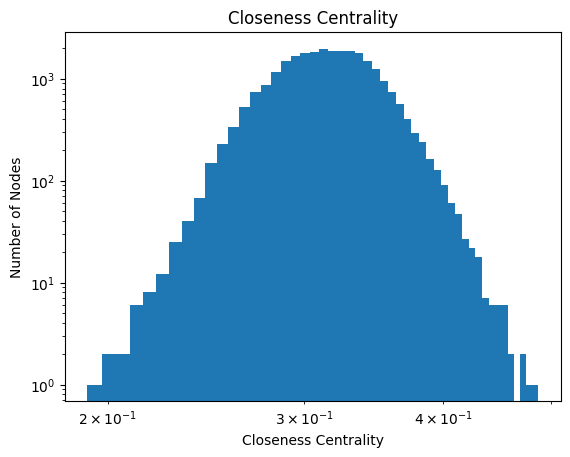

In [239]:
plt.hist(closeness.values(), bins = 50)
plt.title('Closeness Centrality')
plt.xlabel('Closeness Centrality')
plt.loglog()
plt.ylabel('Number of Nodes')

In [240]:
def get_roles(G):
    roles = []
    for node in G.nodes():
        # Global role detection
        if centrality[node] > 1000 and betweenness[node] > 0.01:
            role_g = 'leader'
        elif centrality[node] < 6 and closeness[node] > 0.25:
            role_g = 'gatekeeper'
        else:
            role_g = 'none'
        
        # Local role detection
        if intra_community_degrees[node]>400:
            role_l ='leader'
        elif intra_community_degrees[node]<2:
            role_l ='gatekeeper'
        else:
            role_l = 'none'
        
        roles.append({
        'node': node,
        'flag': G.nodes[node]['flag'],
        'community': comm_map[node],
        'global_role' : role_g,
        'local_role': role_l
    })
        
    return pd.DataFrame(roles)

In [241]:
roles = get_roles(G)
roles

,node,flag,community,global_role,local_role
0,--------_--,e,[173],none,none
1,Juulsteen,e,[2],none,none
2,1Zer0Her0,e,[2],none,none
3,5wings4birds,i,[0],none,none
4,Ak_707,i,[2],none,none
...,...,...,...,...,...
26804,CoolHandMcQueen,i,[0],gatekeeper,gatekeeper
26805,CanStareIntoYourSoul,i,[1],gatekeeper,gatekeeper
26806,xKnightLite,i,[570],none,gatekeeper
26807,SnooHobbies4596,i,[2],gatekeeper,gatekeeper


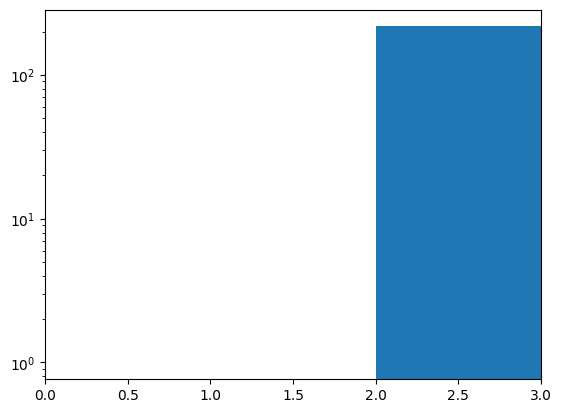

In [242]:
plt.hist(roles['community'].value_counts(), bins = 10000)
plt.xlim(0, 3)
plt.yscale('log')
#plt.xscale('log')

In [243]:
roles['community'].value_counts()

[0]      10493
[1]       7123
[2]       4589
[3]         31
[4]         30
         ...  
[525]        2
[468]        2
[467]        2
[526]        2
[615]        2
Name: community, Length: 616, dtype: int64

In [244]:
roles['global_role'].value_counts()

none          18262
gatekeeper     8525
leader           22
Name: global_role, dtype: int64

In [245]:
roles['local_role'].value_counts()

none          21247
gatekeeper     5514
leader           48
Name: local_role, dtype: int64

In [246]:
roles['flag'].value_counts()

i    18999
e     7810
Name: flag, dtype: int64

In [247]:
g_role_e = roles.loc[roles['flag'] == 'e','global_role']
g_role_i = roles.loc[roles['flag'] == 'i','global_role']
l_role_e = roles.loc[roles['flag'] == 'e','local_role']
l_role_i = roles.loc[roles['flag'] == 'i','local_role']

In [248]:
print('global E roles fraction')
print(g_role_e.value_counts()/7810)
print('\nglobal I roles fraction')
print(g_role_i.value_counts()/18999)


global E roles fraction
none          0.695006
gatekeeper    0.304225
leader        0.000768
Name: global_role, dtype: float64

global I roles fraction
none          0.675509
gatekeeper    0.323649
leader        0.000842
Name: global_role, dtype: float64


In [249]:
print('local I roles fraction')
print(l_role_i.value_counts()/18999)
print('\nlocal E roles fraction')
print(l_role_e.value_counts()/7810)

local I roles fraction
none          0.790199
gatekeeper    0.208169
leader        0.001632
Name: local_role, dtype: float64

local E roles fraction
none          0.798207
gatekeeper    0.199616
leader        0.002177
Name: local_role, dtype: float64
